In [76]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import anndata
from sklearn.preprocessing import StandardScaler

In [62]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

###### scDCC functions

In [108]:
def normalize(adata, filter_min_counts=True, size_factors=True, normalize_input=True, logtrans_input=True,
              var_order=None):

    if filter_min_counts:
        sc.pp.filter_genes(adata, min_counts=1)
        sc.pp.filter_cells(adata, min_counts=1)
        
    # add/reorder vars if needed
    if var_order is not None:
        obs = adata.obs
        a, b = set(var_order), set(adata.var.index.to_list())
        overlap = list(a.intersection(b))
        missing = list(a - set(overlap))
        is_sparse = True if 'sparse' in str(type(adata.X)).lower() else False
        
        new = adata[:, overlap]
        m = anndata.AnnData(X=np.zeros((adata.shape[0], len(missing))), obs=adata.obs)
        m.var.index = missing
        new = anndata.concat((new, m), axis=1)
                
        adata = new[:, var_order]
        adata.obs = obs

    if size_factors or normalize_input or logtrans_input:
        adata.raw = adata.copy()
    else:
        adata.raw = adata

    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0

    if logtrans_input:
        sc.pp.log1p(adata)

    if normalize_input:
        sc.pp.scale(adata)

    return adata


In [109]:
# adapted from
class ZINBLoss(torch.nn.Module):
    def __init__(self):
        super(ZINBLoss, self).__init__()

    def forward(self, x, mean, disp, pi, scale_factor=1.0, ridge_lambda=0.0):
        eps = 1e-10
        scale_factor = scale_factor[:, None]
        mean = mean * scale_factor
        
        t1 = torch.lgamma(disp+eps) + torch.lgamma(x+1.0) - torch.lgamma(x+disp+eps)
        t2 = (disp+x) * torch.log(1.0 + (mean/(disp+eps))) + (x * (torch.log(disp+eps) - torch.log(mean+eps)))
        nb_final = t1 + t2

        nb_case = nb_final - torch.log(1.0-pi+eps)
        zero_nb = torch.pow(disp/(disp+mean+eps), disp)
        zero_case = -torch.log(pi + ((1.0-pi)*zero_nb)+eps)
        result = torch.where(torch.le(x, 1e-8), zero_case, nb_case)
        
        if ridge_lambda > 0:
            ridge = ridge_lambda*torch.square(pi)
            result += ridge
        
        result = torch.mean(result)
        return result
    
    
class MeanAct(torch.nn.Module):
    def __init__(self):
        super(MeanAct, self).__init__()

    def forward(self, x):
        return torch.clamp(torch.exp(x), min=1e-5, max=1e6)

    
class DispAct(torch.nn.Module):
    def __init__(self):
        super(DispAct, self).__init__()

    def forward(self, x):
        return torch.clamp(F.softplus(x), min=1e-4, max=1e4)

###### start

In [110]:
a = sc.read_h5ad('/data/pollock/benchmarking/pollock_datasets/scRNAseq/brca_train.h5ad')
a = normalize(a)
a

AnnData object with n_obs × n_vars = 6105 × 23553
    obs: 'cell_type', 'barcode', 'sample', 'n_counts', 'size_factors'
    var: 'n_counts', 'mean', 'std'
    uns: 'log1p'

In [111]:
v = sc.read_h5ad('/data/pollock/benchmarking/pollock_datasets/scRNAseq/brca_val.h5ad')
v = normalize(v, var_order=a.var.index.to_list())
v

AnnData object with n_obs × n_vars = 5748 × 23553
    obs: 'cell_type', 'barcode', 'sample', 'n_counts', 'size_factors'
    var: 'mean', 'std'
    uns: 'log1p'

In [113]:
v.obs

,cell_type,barcode,sample,n_counts,size_factors
0_AACCAACTCCACTAGA-1,Endothelial,AACCAACTCCACTAGA-1,0,4712.0,1.213182
0_AACCCAAAGACGAGCT-1,NK,AACCCAAAGACGAGCT-1,0,4732.0,1.218332
0_AACGTCAGTTTACACG-1,Endothelial,AACGTCAGTTTACACG-1,0,3294.0,0.848095
0_AACTTCTGTCCAGAAG-1,CD8 T cell,AACTTCTGTCCAGAAG-1,0,3202.0,0.824408
0_AAGCCATAGTGATTCC-1,Endothelial,AAGCCATAGTGATTCC-1,0,4088.0,1.052523
...,...,...,...,...,...
29_TTTATGCCAGCCCAGT-1,Fibroblast,TTTATGCCAGCCCAGT-1,29,4480.0,1.153450
29_TTTCATGGTCGACTTA-1,Treg,TTTCATGGTCGACTTA-1,29,4580.0,1.179197
29_TTTCCTCGTTAGCGGA-1,Treg,TTTCCTCGTTAGCGGA-1,29,4525.0,1.165036
29_TTTGACTCATGGGATG-1,Plasma,TTTGACTCATGGGATG-1,29,4452.0,1.146241


In [115]:
np.count_nonzero(a.var.index != v.var.index)

0

In [276]:
#dataset = TensorDataset(torch.Tensor(x), torch.Tensor(X_raw), torch.Tensor(size_factor))
class PollockDataset(Dataset):
    """Pollock Dataset"""
    def __init__(self, adata, label_col='cell_type'):
        self.adata = adata

        if label_col in adata.obs.columns:
            self.cell_types = sorted(set(adata.obs[label_col]))
            self.labels = adata.obs[label_col].to_list()
        else:
            self.cell_types = None
            self.labels = None
        
    def __len__(self):
        return self.adata.shape[0]

    def __getitem__(self, idx):
        x = self.adata.X[idx]
        if 'sparse' in str(type(x)).lower():
            x = x.toarray()
        
        x_raw = self.adata.raw.X[idx]
        if 'sparse' in str(type(x_raw)).lower():
            x_raw = x_raw.toarray()
        
        x, x_raw = np.squeeze(x), np.squeeze(x_raw)

        sf = self.adata.obs['size_factors'][idx]
        
        label = self.labels[idx] if self.labels is not None else None
        y = self.cell_types.index(label) if label is not None else None
        
        return {
            'x': x,
            'x_raw': x_raw,
            'size_factor': sf,
            'y': y,
            'label': label
        }
    
def get_train_dataloaders(train_fp, val_fp, batch_size=64):
    train_adata = sc.read_h5ad(train_fp)
    val_adata = sc.read_h5ad(val_fp)
    
    train_adata = normalize(train_adata)
    val_adata = normalize(val_adata, var_order=train_adata.var.index.to_list())
    
    train_ds = PollockDataset(train_adata)
    val_ds = PollockDataset(val_adata)
    
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    
    return train_dl, val_dl

def get_prediction_dataloader(fp, var_order, batch_size=64):
    adata = sc.read_h5ad(fp)
    
    adata = normalize(adata, var_order=var_order)
    
    ds = PollockDataset(adata)
    
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)
    
    return dl

In [191]:
train_fp = '/data/pollock/benchmarking/pollock_datasets/scRNAseq/brca_train.h5ad'
val_fp = '/data/pollock/benchmarking/pollock_datasets/scRNAseq/brca_val.h5ad'
train_dl, val_dl = get_train_dataloaders(train_fp, val_fp)

In [192]:
b = next(iter(train_dl))
b['x'].shape, b['x_raw'].shape, b['size_factor'], b['y'], b['label']

(torch.Size([64, 23553]),
 torch.Size([64, 23553]),
 tensor([0.8479, 1.2145, 1.1846, 1.1945, 1.1505, 0.8550, 1.0632, 1.0873, 1.1715,
         1.1649, 0.8149, 1.0341, 1.2216, 0.8820, 0.9208, 1.2281, 0.8870, 0.9164,
         1.0128, 1.1251, 1.2098, 0.7590, 0.8487, 0.9061, 0.9565, 0.9035, 1.2213,
         0.8922, 1.1856, 1.1293, 1.1460, 1.0758, 0.9483, 1.1177, 1.0317, 0.7981,
         0.8584, 1.1054, 1.0443, 0.8117, 1.0008, 1.0034, 1.0983, 0.8571, 1.0886,
         1.1382, 1.2061, 0.9733, 0.8495, 0.9483, 1.3686, 0.7431, 0.9604, 1.0781,
         1.0388, 0.9908, 1.2029, 0.9114, 0.9124, 0.8545, 1.1492, 1.0797, 0.9997,
         1.1699]),
 tensor([ 1,  9,  1,  0,  2,  2,  6,  5,  2,  2,  5,  4,  9,  2,  0,  9, 12,  0,
          7, 12,  8,  7, 10,  8,  2,  1, 11,  0,  0,  6,  6,  3,  8,  7,  1,  7,
         10,  1, 10, 11,  9,  6,  1,  6,  1,  3,  1,  2,  4, 10, 11,  5, 12,  6,
         12,  2,  1,  3, 12,  9,  3,  4, 11, 12]),
 ['CD4 T cell',
  'Monocyte',
  'CD4 T cell',
  'B cell',
  'CD8 T c

In [306]:
class PollockModel(torch.nn.Module):
    def __init__(self, genes, classes, latent_dim=64, enc_out_dim=128, middle_dim=512,
                 zinb_scaler=1., kl_scaler=1e-5, clf_scaler=1.):
        """
        """
        super(PollockModel, self).__init__()
        self.latent_dim = latent_dim
        self.genes = genes
        self.n_genes = len(genes)
        self.classes = classes
        self.n_classes = len(classes)
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.n_genes, middle_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(middle_dim, enc_out_dim),
            torch.nn.ReLU(),
        )
        
        self.mu = torch.nn.Linear(enc_out_dim, latent_dim)
        self.var = torch.nn.Linear(enc_out_dim, latent_dim)
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, enc_out_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(enc_out_dim, middle_dim),
            torch.nn.ReLU(),
        )
        self.disp_decoder = torch.nn.Sequential(
            torch.nn.Linear(middle_dim, self.n_genes),
            DispAct()
        )
        self.mean_decoder = torch.nn.Sequential(
            torch.nn.Linear(middle_dim, self.n_genes),
            MeanAct()
        )
        self.drop_decoder = torch.nn.Sequential(
            torch.nn.Linear(middle_dim, self.n_genes),
            torch.nn.Sigmoid()
        )
        
        self.prediction_head = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, latent_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(latent_dim, self.n_classes),
            torch.nn.Softmax(dim=1),
        )
        
        self.zinb_loss = ZINBLoss()
        self.ce_loss = torch.nn.CrossEntropyLoss()
        self.zinb_scaler = zinb_scaler
        self.kl_scaler = kl_scaler
        self.clf_scaler = clf_scaler
        
    def kl_divergence(self, z, mu, std):
        # lightning imp.
        # Monte carlo KL divergence
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        
        return kl
        
    def encode(self, x, use_means=False):
        x_encoded = self.encoder(x)
        mu, log_var = self.mu(x_encoded), self.var(x_encoded)

        # sample z from parameterized distributions
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        # get our latent
        if use_means:
            z = mu
        else:
            z = q.rsample()
        
        return z, mu, std
    
    def decode(self, x):
        h = self.decoder(x)
        x_disp = self.disp_decoder(h)
        x_mean = self.mean_decoder(h)
        x_drop = self.drop_decoder(h)
        
        return x_disp, x_mean, x_drop
    
    def calculate_loss(self, r, x_raw, scale_factor, y_true):
        reconstruction_loss = self.zinb_loss(
            x_raw, r['x_mean'], r['x_disp'], r['x_drop'], scale_factor=scale_factor)
        
        kl_loss = torch.mean(self.kl_divergence(r['z'], r['mu'], r['std']))
        
        clf_loss = torch.mean(self.ce_loss(r['y'], y_true))
        
        return ((reconstruction_loss * self.zinb_scaler) + (kl_loss * self.kl_scaler) + (clf_loss * self.clf_scaler),
                reconstruction_loss,
                kl_loss,
                clf_loss)
        
    def forward(self, x, use_means=False):
        z, mu, std = self.encode(x, use_means=use_means)
        x_disp, x_mean, x_drop = self.decode(z)
        y = self.prediction_head(z)
        
        return {
            'z': z,
            'mu': mu,
            'std': std,
            'x_disp': x_disp,
            'x_mean': x_mean,
            'x_drop': x_drop,
            'y': y
        }

In [281]:
cuda = True
model = PollockModel(train_dl.dataset.adata.var.index.to_list(), train_dl.dataset.cell_types,
                     latent_dim=64, enc_out_dim=128, middle_dim=512,
                     kl_scaler=1e-3, clf_scaler=1., zinb_scaler=1.)
model = model.cuda()

epochs = 20
lr = 1e-4
opt = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    opt, max_lr=lr, steps_per_epoch=len(train_dl), epochs=epochs)

In [282]:
import time
for epoch in range(epochs):
    train_loss, val_loss = 0., 0.
    val_recon_loss, val_kl_loss, val_clf_loss = 0., 0., 0.
    start = time.time()
    model.train()
    for i, b in enumerate(train_dl):
        x, x_raw, sf, y = b['x'], b['x_raw'], b['size_factor'], b['y']
        if cuda:
            x, x_raw, sf, y = x.cuda(), x_raw.cuda(), sf.cuda(), y.cuda()
        opt.zero_grad()
        out = model(x)
        loss, recon_loss, kl_loss, clf_loss = model.calculate_loss(out, x_raw, sf, y)
        loss.backward()
#         recon_loss.backward()
        opt.step()
 
        train_loss += float(loss.detach().cpu())
        scheduler.step()
    train_loss = train_loss / len(train_dl)

    time_delta = time.time() - start
    model.eval()
    with torch.no_grad():
        for i, b in enumerate(val_dl):
            x, x_raw, sf, y = b['x'], b['x_raw'], b['size_factor'], b['y']
            if cuda:
                x, x_raw, sf, y = x.cuda(), x_raw.cuda(), sf.cuda(), y.cuda()
                
            out = model(x)
            loss, recon_loss, kl_loss, clf_loss = model.calculate_loss(out, x_raw, sf, y)
            val_loss += float(loss.detach().cpu())
            val_recon_loss += float(recon_loss.detach().cpu())
            val_kl_loss += float(kl_loss.detach().cpu())
            val_clf_loss += float(clf_loss.detach().cpu())
            
    val_loss, val_recon_loss, val_kl_loss, val_clf_loss = [
        l / len(val_dl) for l in [val_loss, val_recon_loss, val_kl_loss, val_clf_loss]]
    
    print(f'epoch: {epoch}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}, \
vr loss: {val_recon_loss:.3f}, vkl loss: {val_kl_loss:.3f}, clf loss: {val_clf_loss:.3f}, time: {time_delta:.2f}')

epoch: 0, train loss: 2.998, val loss: 2.991, vr loss: 0.428, vkl loss: 0.651, clf loss: 2.562, time: 3.33
epoch: 1, train loss: 2.969, val loss: 2.920, vr loss: 0.375, vkl loss: 7.676, clf loss: 2.538, time: 3.23
epoch: 2, train loss: 2.756, val loss: 2.598, vr loss: 0.228, vkl loss: 82.038, clf loss: 2.288, time: 3.25
epoch: 3, train loss: 2.461, val loss: 2.376, vr loss: 0.214, vkl loss: 103.685, clf loss: 2.058, time: 3.22
epoch: 4, train loss: 2.255, val loss: 2.289, vr loss: 0.208, vkl loss: 77.969, clf loss: 2.003, time: 3.22
epoch: 5, train loss: 2.121, val loss: 2.199, vr loss: 0.206, vkl loss: 76.276, clf loss: 1.916, time: 3.21
epoch: 6, train loss: 2.026, val loss: 2.169, vr loss: 0.205, vkl loss: 61.037, clf loss: 1.903, time: 3.23
epoch: 7, train loss: 1.997, val loss: 2.160, vr loss: 0.204, vkl loss: 51.800, clf loss: 1.904, time: 3.24
epoch: 8, train loss: 1.982, val loss: 2.146, vr loss: 0.204, vkl loss: 46.984, clf loss: 1.896, time: 3.23
epoch: 9, train loss: 1.972, 

In [313]:
import json
json.dump()

In [283]:
def predict_dl(dl, model):
    emb, y_prob, y_true = None, None, None
    model.eval()
    with torch.no_grad():
        for i, b in enumerate(dl):
            x, x_raw, sf, y = b['x'], b['x_raw'], b['size_factor'], b['y']
            if cuda:
                x, x_raw, sf, y = x.cuda(), x_raw.cuda(), sf.cuda(), y.cuda()

            r = model(x, use_means=True)

            b_emb = r['z'].detach().cpu().numpy()
            b_y_prob = r['y'].detach().cpu().numpy()
            b_y_true = y.detach().cpu().numpy()

            if emb is None:
                emb = b_emb
                y_prob = b_y_prob
                y_true = b_y_true
            else:
                emb = np.concatenate((emb, b_emb), axis=0)
                y_prob = np.concatenate((y_prob, b_y_prob), axis=0)
                y_true = np.concatenate((y_true, b_y_true), axis=0)
    return emb, y_prob, y_true

def predict_adata(model, fp, umap_fit_n=10000):
    dl = get_prediction_dataloader(fp, model.genes, batch_size=1024)
    emb, y_prob, y_true = predict_dl(dl, model)
    a = dl.dataset.adata
    
    u = UMAP()
    idxs = np.random.choice(np.arange(a.shape[0]), size=min(umap_fit_n, a.shape[0]), replace=False)
    u.fit(emb[idxs])
    a.obsm['X_emb'] = emb
    a.obsm['X_umap'] = u.transform(emb)
    a.obsm['prediction_probs'] = y_prob
    a.obs['y_true'] = [model.classes.index(x) if x in model.classes else None for x in a.obs['cell_type']]
    a.obs['y_pred'] = [np.argmax(probs) for probs in y_prob]
    a.obs['prediction_prob'] = [np.max(probs) for probs in y_prob]
    a.obs['predicted_cell_type'] = [val_dl.dataset.cell_types[np.argmax(probs)] for probs in y_prob]
    return a

In [284]:
a = predict_adata(model, '/data/pollock/benchmarking/pollock_datasets/scRNAseq/brca_val.h5ad')
a

AnnData object with n_obs × n_vars = 5748 × 23553
    obs: 'cell_type', 'barcode', 'sample', 'n_counts', 'size_factors', 'y_true', 'y_pred', 'prediction_prob', 'predicted_cell_type'
    var: 'mean', 'std'
    uns: 'log1p'
    obsm: 'X_emb', 'X_umap', 'prediction_probs'

In [285]:
a.obs

,cell_type,barcode,sample,n_counts,size_factors,y_true,y_pred,prediction_prob,predicted_cell_type
0_AACCAACTCCACTAGA-1,Endothelial,AACCAACTCCACTAGA-1,0,4712.0,1.213182,4,4,0.994776,Endothelial
0_AACCCAAAGACGAGCT-1,NK,AACCCAAAGACGAGCT-1,0,4732.0,1.218332,10,10,0.994027,NK
0_AACGTCAGTTTACACG-1,Endothelial,AACGTCAGTTTACACG-1,0,3294.0,0.848095,4,4,0.966932,Endothelial
0_AACTTCTGTCCAGAAG-1,CD8 T cell,AACTTCTGTCCAGAAG-1,0,3202.0,0.824408,2,2,0.968903,CD8 T cell
0_AAGCCATAGTGATTCC-1,Endothelial,AAGCCATAGTGATTCC-1,0,4088.0,1.052523,4,4,0.989221,Endothelial
...,...,...,...,...,...,...,...,...,...
29_TTTATGCCAGCCCAGT-1,Fibroblast,TTTATGCCAGCCCAGT-1,29,4480.0,1.153450,6,6,0.953083,Fibroblast
29_TTTCATGGTCGACTTA-1,Treg,TTTCATGGTCGACTTA-1,29,4580.0,1.179197,12,12,0.990401,Treg
29_TTTCCTCGTTAGCGGA-1,Treg,TTTCCTCGTTAGCGGA-1,29,4525.0,1.165036,12,12,0.985880,Treg
29_TTTGACTCATGGGATG-1,Plasma,TTTGACTCATGGGATG-1,29,4452.0,1.146241,11,11,0.998505,Plasma


/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


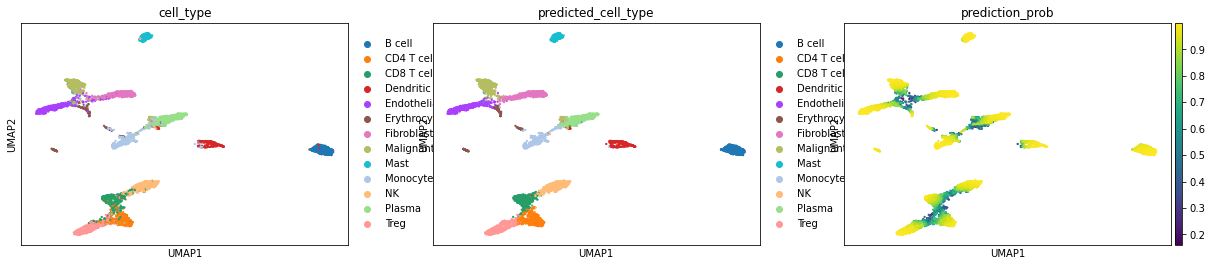

In [286]:
sc.pl.umap(a, color=['cell_type', 'predicted_cell_type', 'prediction_prob'])

In [287]:
from sklearn.metrics import f1_score, accuracy_score
f1_score(a.obs['y_true'], a.obs['y_pred'], average='weighted'), accuracy_score(a.obs['y_true'], a.obs['y_pred'])

(0.8849522061654301, 0.8850034794711203)

In [288]:
from mgitools.os_helpers import listfiles

In [289]:
val_fps = sorted(listfiles('/data/pollock/benchmarking/pollock_datasets/scRNAseq/', regex=r'val.h5ad$'))
val_fps

['/data/pollock/benchmarking/pollock_datasets/scRNAseq/brca_val.h5ad',
 '/data/pollock/benchmarking/pollock_datasets/scRNAseq/cesc_val.h5ad',
 '/data/pollock/benchmarking/pollock_datasets/scRNAseq/hnscc_val.h5ad',
 '/data/pollock/benchmarking/pollock_datasets/scRNAseq/melanoma_val.h5ad',
 '/data/pollock/benchmarking/pollock_datasets/scRNAseq/myeloma_val.h5ad',
 '/data/pollock/benchmarking/pollock_datasets/scRNAseq/pdac_val.h5ad']

In [290]:
results_dict = {}
for fp in val_fps:
    disease = fp.split('/')[-1].split('_')[0]
    print(disease)
    a = predict_adata(model, fp)
    results_dict[disease] = a

brca
cesc
hnscc
melanoma
myeloma
pdac


/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


brca 0.889553165907668 0.8850034794711203


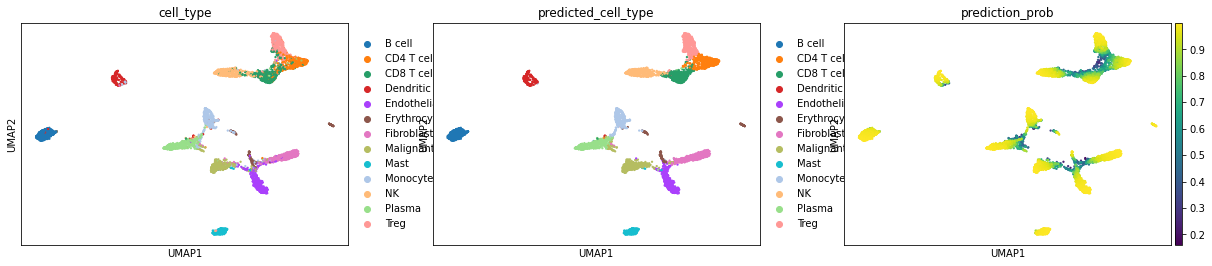

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


cesc 0.41904653220205934 0.5950741525423728


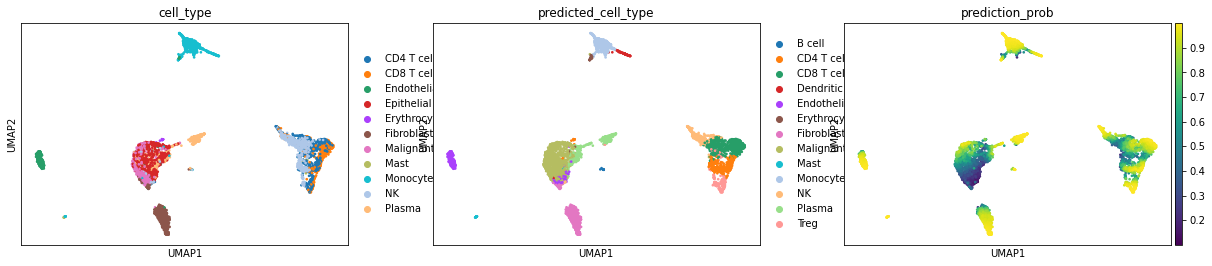

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


hnscc 0.6059208378733774 0.7340895981542012


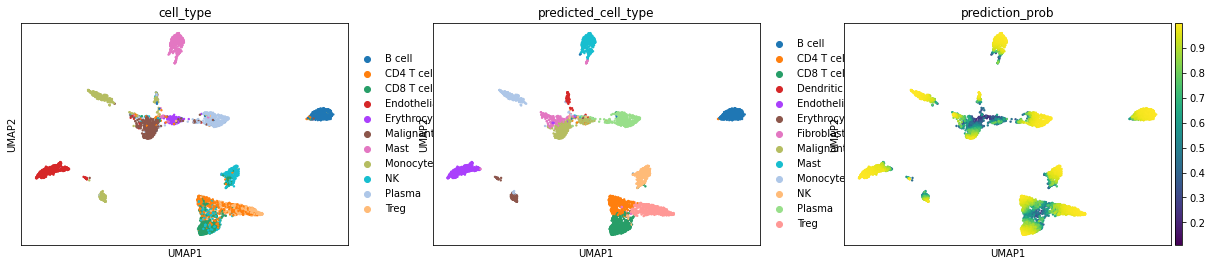

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


melanoma 0.6570259816814338 0.8475973841342053


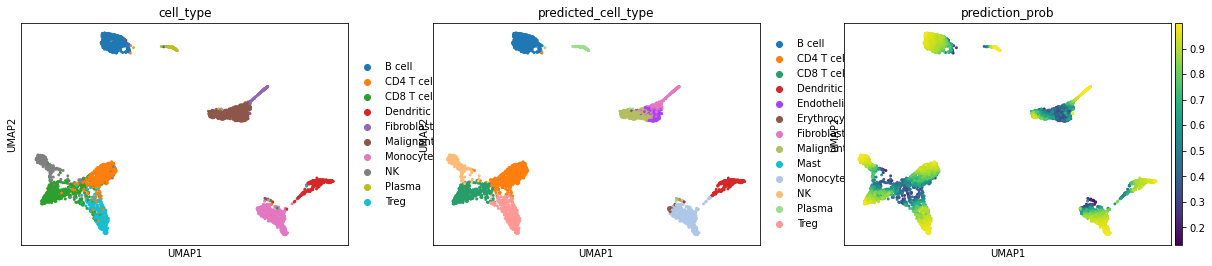

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


myeloma 0.4667951701370294 0.7061668681983071


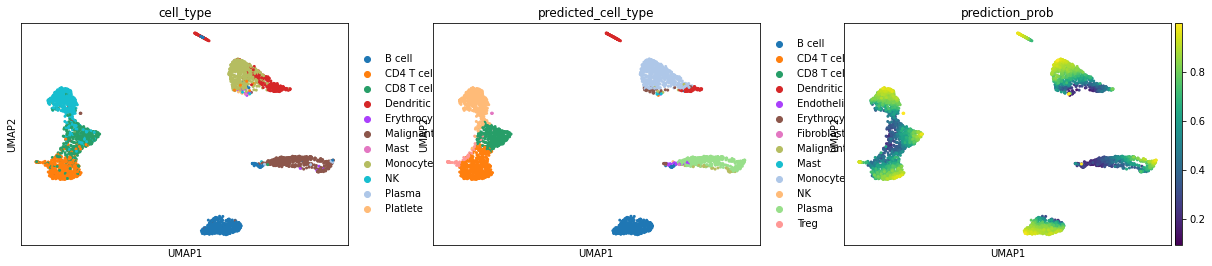

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


pdac 0.7213967089945782 0.7753577106518283


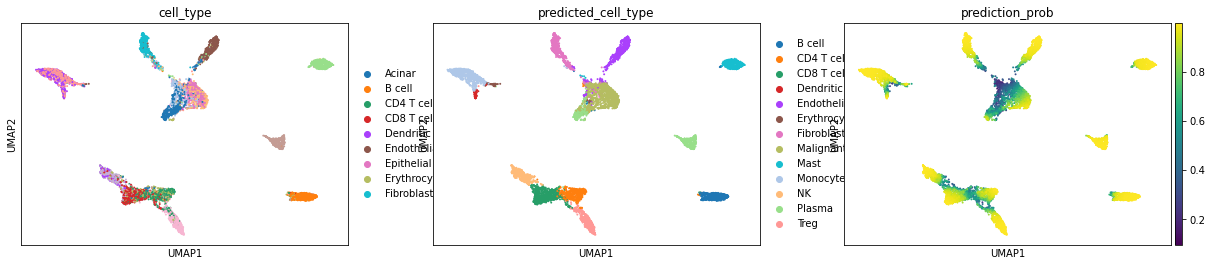

In [291]:
for k, a in results_dict.items():
    # fix y_true
    a.obs['y_true'] = [model.classes.index(x) if x in model.classes else None for x in a.obs['cell_type']]
    overlap = set(a.obs['cell_type']).intersection(set(model.classes))
    f = a[[True if c in overlap else False for c in a.obs['predicted_cell_type']]]
    f = a[~pd.isnull(a.obs['y_true'])]
    f1 = f1_score(f.obs['y_true'], f.obs['y_pred'], average='macro')
    acc = accuracy_score(f.obs['y_true'], f.obs['y_pred'])
    print(k, f1, acc)
    sc.pl.umap(a, color=['cell_type', 'predicted_cell_type', 'prediction_prob'])
    plt.show()

In [292]:
train_fps = sorted(listfiles('/data/pollock/benchmarking/pollock_datasets/scRNAseq/', regex=r'train.h5ad$'))
train_fps

['/data/pollock/benchmarking/pollock_datasets/scRNAseq/brca_train.h5ad',
 '/data/pollock/benchmarking/pollock_datasets/scRNAseq/cesc_train.h5ad',
 '/data/pollock/benchmarking/pollock_datasets/scRNAseq/hnscc_train.h5ad',
 '/data/pollock/benchmarking/pollock_datasets/scRNAseq/melanoma_train.h5ad',
 '/data/pollock/benchmarking/pollock_datasets/scRNAseq/myeloma_train.h5ad',
 '/data/pollock/benchmarking/pollock_datasets/scRNAseq/pdac_train.h5ad']

In [293]:
val_fps = sorted(listfiles('/data/pollock/benchmarking/pollock_datasets/scRNAseq/', regex=r'val.h5ad$'))
val_fps

['/data/pollock/benchmarking/pollock_datasets/scRNAseq/brca_val.h5ad',
 '/data/pollock/benchmarking/pollock_datasets/scRNAseq/cesc_val.h5ad',
 '/data/pollock/benchmarking/pollock_datasets/scRNAseq/hnscc_val.h5ad',
 '/data/pollock/benchmarking/pollock_datasets/scRNAseq/melanoma_val.h5ad',
 '/data/pollock/benchmarking/pollock_datasets/scRNAseq/myeloma_val.h5ad',
 '/data/pollock/benchmarking/pollock_datasets/scRNAseq/pdac_val.h5ad']

In [310]:
def build_model(train_dl, cuda=True, epochs=20, lr=1e-4):
    model = PollockModel(train_dl.dataset.adata.var.index.to_list(), train_dl.dataset.cell_types,
                         latent_dim=64, enc_out_dim=128, middle_dim=512,
                         kl_scaler=1e-4, clf_scaler=1., zinb_scaler=.5)
    model = model.cuda()

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        opt, max_lr=lr, steps_per_epoch=len(train_dl), epochs=epochs)
    
    return model, opt, scheduler

def fit_model(model, train_dl, val_dl, opt, scheduler, cuda=True):
    for epoch in range(epochs):
        train_loss, val_loss = 0., 0.
        val_recon_loss, val_kl_loss, val_clf_loss = 0., 0., 0.
        start = time.time()
        model.train()
        for i, b in enumerate(train_dl):
            x, x_raw, sf, y = b['x'], b['x_raw'], b['size_factor'], b['y']
            if cuda:
                x, x_raw, sf, y = x.cuda(), x_raw.cuda(), sf.cuda(), y.cuda()
            opt.zero_grad()
            out = model(x)
            loss, recon_loss, kl_loss, clf_loss = model.calculate_loss(out, x_raw, sf, y)
            loss.backward()
            opt.step()

            train_loss += float(loss.detach().cpu())
            scheduler.step()
        train_loss = train_loss / len(train_dl)

        time_delta = time.time() - start
        model.eval()
        with torch.no_grad():
            for i, b in enumerate(val_dl):
                x, x_raw, sf, y = b['x'], b['x_raw'], b['size_factor'], b['y']
                if cuda:
                    x, x_raw, sf, y = x.cuda(), x_raw.cuda(), sf.cuda(), y.cuda()

                out = model(x)
                loss, recon_loss, kl_loss, clf_loss = model.calculate_loss(out, x_raw, sf, y)
                val_loss += float(loss.detach().cpu())
                val_recon_loss += float(recon_loss.detach().cpu())
                val_kl_loss += float(kl_loss.detach().cpu())
                val_clf_loss += float(clf_loss.detach().cpu())

        val_loss, val_recon_loss, val_kl_loss, val_clf_loss = [
            l / len(val_dl) for l in [val_loss, val_recon_loss, val_kl_loss, val_clf_loss]]

        print(f'epoch: {epoch}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}, \
    vr loss: {val_recon_loss:.3f}, vkl loss: {val_kl_loss:.3f}, clf loss: {val_clf_loss:.3f}, time: {time_delta:.2f}')

In [311]:
def evaluate_results(results_dict):
    for k, a in results_dict.items():
        overlap = set(a.obs['cell_type']).intersection(set(model.classes))
        f = a[[True if c in overlap else False for c in a.obs['predicted_cell_type']]]
        f = a[~pd.isnull(a.obs['y_true'])]
        f1 = f1_score(f.obs['y_true'], f.obs['y_pred'], average='weighted')
        acc = accuracy_score(f.obs['y_true'], f.obs['y_pred'])
        print(k, f1, acc)
        sc.pl.umap(a, color=['cell_type', 'predicted_cell_type', 'prediction_prob'])
        plt.show()

brca
epoch: 0, train loss: 2.781, val loss: 2.778,     vr loss: 0.428, vkl loss: 0.743, clf loss: 2.564, time: 3.27
epoch: 1, train loss: 2.764, val loss: 2.735,     vr loss: 0.375, vkl loss: 7.457, clf loss: 2.547, time: 3.25
epoch: 2, train loss: 2.546, val loss: 2.365,     vr loss: 0.226, vkl loss: 277.410, clf loss: 2.225, time: 3.24
epoch: 3, train loss: 2.186, val loss: 2.122,     vr loss: 0.211, vkl loss: 352.217, clf loss: 1.981, time: 3.25
epoch: 4, train loss: 1.969, val loss: 2.001,     vr loss: 0.205, vkl loss: 356.018, clf loss: 1.863, time: 3.24
epoch: 5, train loss: 1.860, val loss: 1.987,     vr loss: 0.203, vkl loss: 259.320, clf loss: 1.860, time: 3.22
epoch: 6, train loss: 1.836, val loss: 1.980,     vr loss: 0.203, vkl loss: 207.067, clf loss: 1.858, time: 3.23
epoch: 7, train loss: 1.826, val loss: 1.977,     vr loss: 0.202, vkl loss: 180.075, clf loss: 1.858, time: 3.24
epoch: 8, train loss: 1.820, val loss: 1.974,     vr loss: 0.202, vkl loss: 162.028, clf loss: 

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


brca 0.8851950582499949 0.8855254001391788


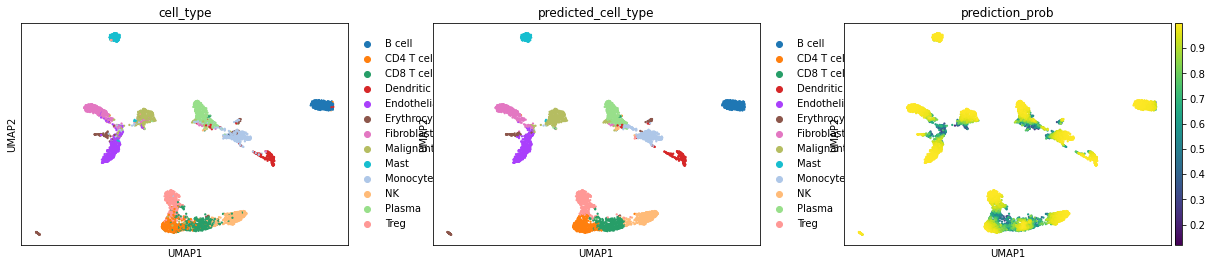

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


cesc 0.5963088945540206 0.5794491525423728


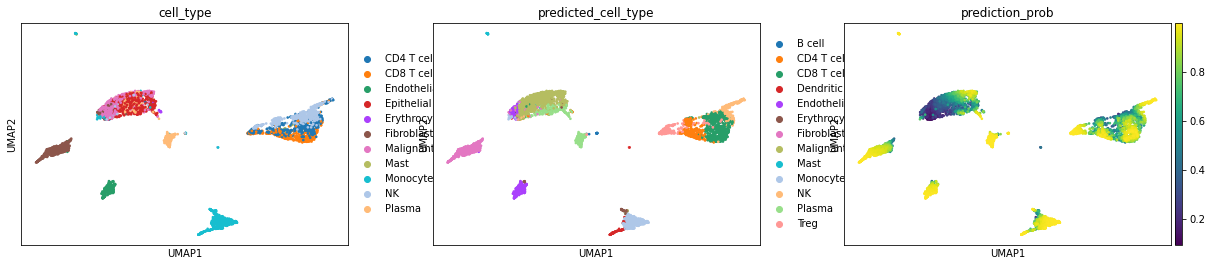

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


hnscc 0.7560828804398121 0.7377427417804269


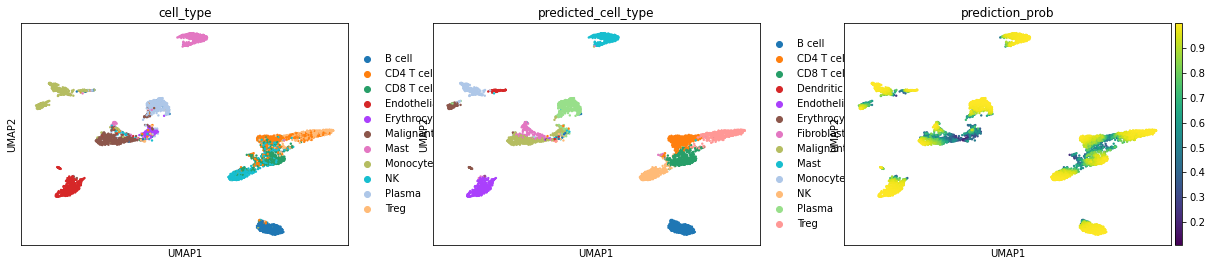

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


melanoma 0.841491492009242 0.8274097241967586


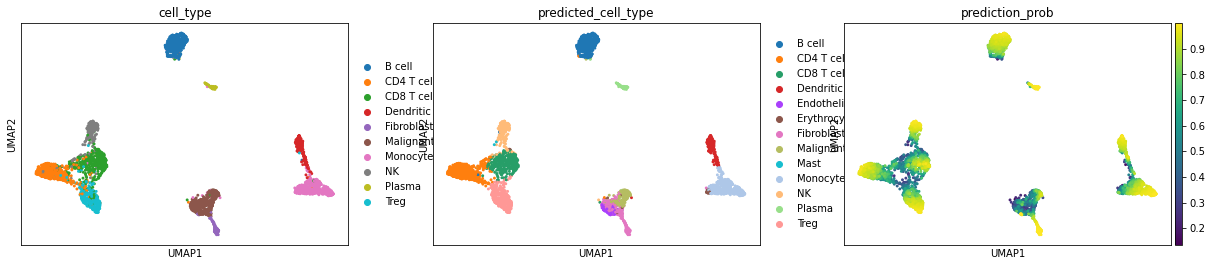

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


myeloma 0.7044735107038972 0.6967956469165659


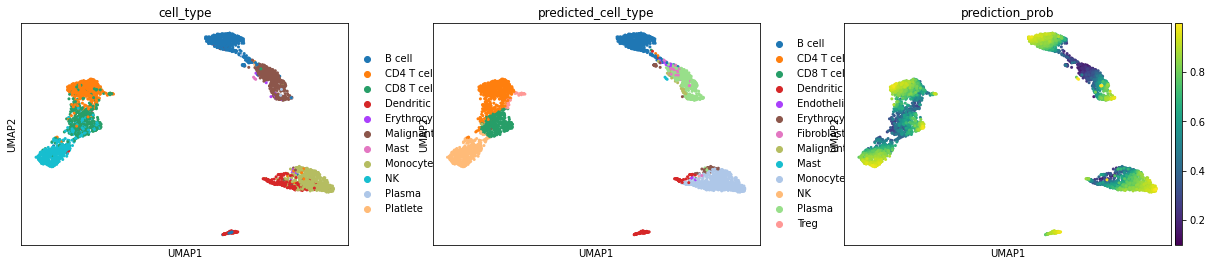

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


pdac 0.7459432351182014 0.7742448330683624


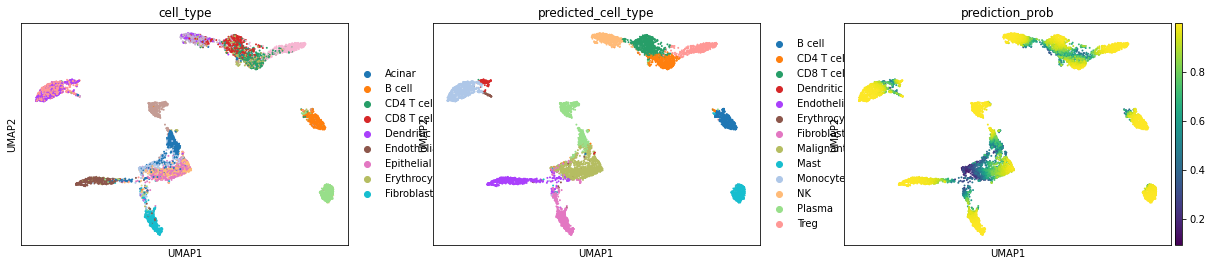

cesc
epoch: 0, train loss: 2.665, val loss: 2.661,     vr loss: 0.533, vkl loss: 0.712, clf loss: 2.394, time: 2.10
epoch: 1, train loss: 2.641, val loss: 2.599,     vr loss: 0.500, vkl loss: 15.346, clf loss: 2.347, time: 2.10
epoch: 2, train loss: 2.359, val loss: 2.105,     vr loss: 0.317, vkl loss: 340.420, clf loss: 1.912, time: 2.13
epoch: 3, train loss: 1.934, val loss: 1.840,     vr loss: 0.286, vkl loss: 391.720, clf loss: 1.658, time: 2.11
epoch: 4, train loss: 1.798, val loss: 1.791,     vr loss: 0.278, vkl loss: 300.685, clf loss: 1.622, time: 2.13
epoch: 5, train loss: 1.761, val loss: 1.779,     vr loss: 0.274, vkl loss: 247.711, clf loss: 1.617, time: 2.12
epoch: 6, train loss: 1.737, val loss: 1.769,     vr loss: 0.272, vkl loss: 234.536, clf loss: 1.610, time: 2.09
epoch: 7, train loss: 1.717, val loss: 1.762,     vr loss: 0.270, vkl loss: 206.985, clf loss: 1.606, time: 2.10
epoch: 8, train loss: 1.710, val loss: 1.759,     vr loss: 0.269, vkl loss: 184.971, clf loss:

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


brca 0.5787642118553928 0.5824396782841823


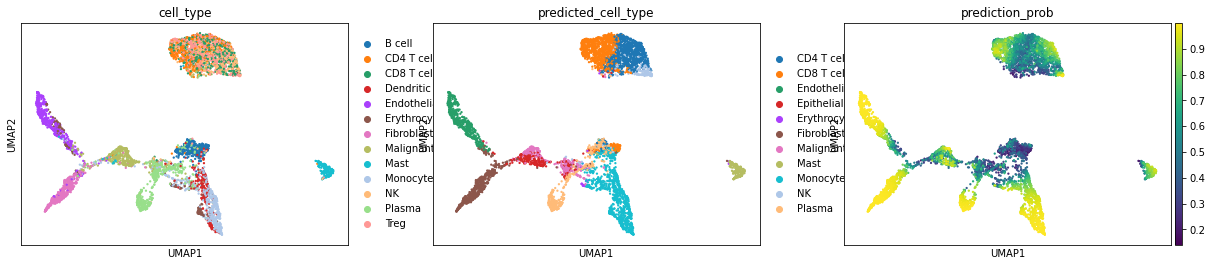

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


cesc 0.9710400578625492 0.9707670720299345


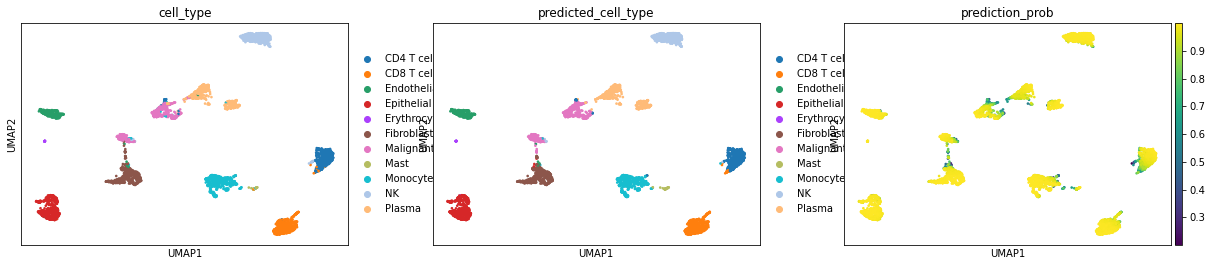

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


hnscc 0.632483097493213 0.6103308736015235


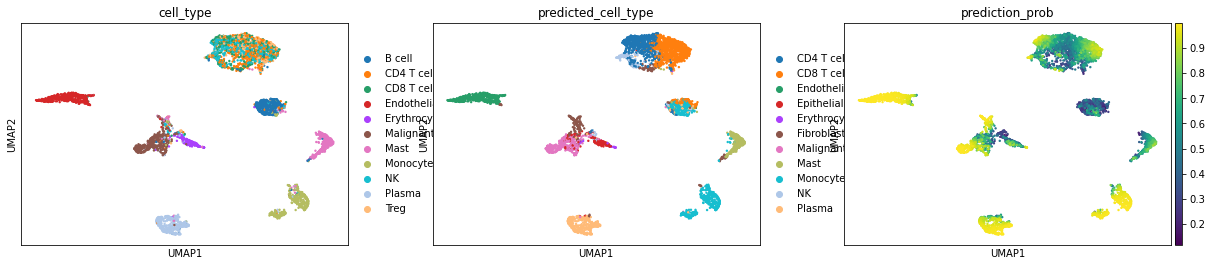

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


melanoma 0.4280139142696305 0.4407622203811102


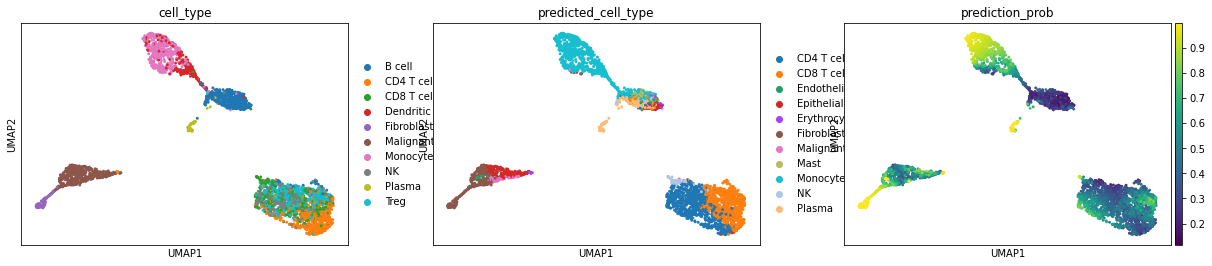

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


myeloma 0.34342326062405126 0.3610122578094108


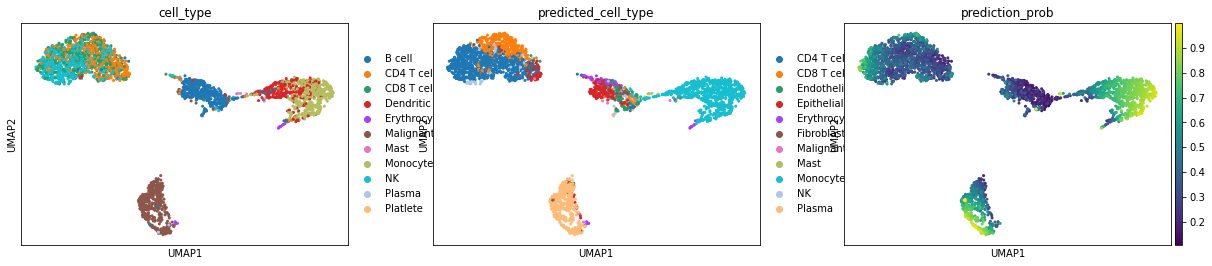

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


pdac 0.6117573253422507 0.6396975425330813


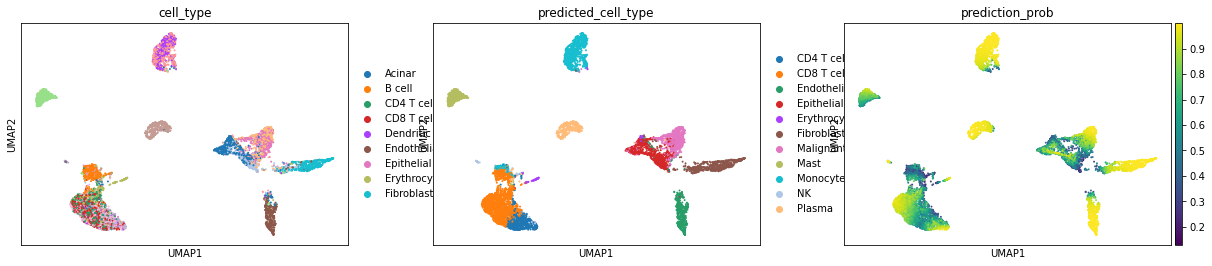

hnscc
epoch: 0, train loss: 2.636, val loss: 2.632,     vr loss: 0.475, vkl loss: 0.707, clf loss: 2.394, time: 2.74
epoch: 1, train loss: 2.616, val loss: 2.576,     vr loss: 0.432, vkl loss: 11.770, clf loss: 2.359, time: 2.75
epoch: 2, train loss: 2.389, val loss: 2.181,     vr loss: 0.259, vkl loss: 287.996, clf loss: 2.023, time: 2.73
epoch: 3, train loss: 2.039, val loss: 1.980,     vr loss: 0.241, vkl loss: 303.851, clf loss: 1.829, time: 2.59
epoch: 4, train loss: 1.876, val loss: 1.886,     vr loss: 0.233, vkl loss: 331.608, clf loss: 1.736, time: 2.76
epoch: 5, train loss: 1.744, val loss: 1.845,     vr loss: 0.231, vkl loss: 260.410, clf loss: 1.703, time: 2.75
epoch: 6, train loss: 1.709, val loss: 1.838,     vr loss: 0.230, vkl loss: 207.662, clf loss: 1.702, time: 2.74
epoch: 7, train loss: 1.698, val loss: 1.836,     vr loss: 0.229, vkl loss: 181.355, clf loss: 1.703, time: 2.75
epoch: 8, train loss: 1.691, val loss: 1.833,     vr loss: 0.229, vkl loss: 162.406, clf loss

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


brca 0.7699481981129667 0.7859726688102894


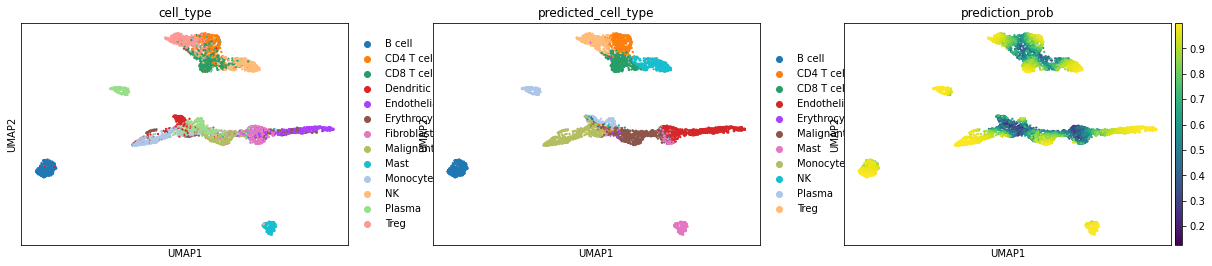

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


cesc 0.5664937430625725 0.5595238095238095


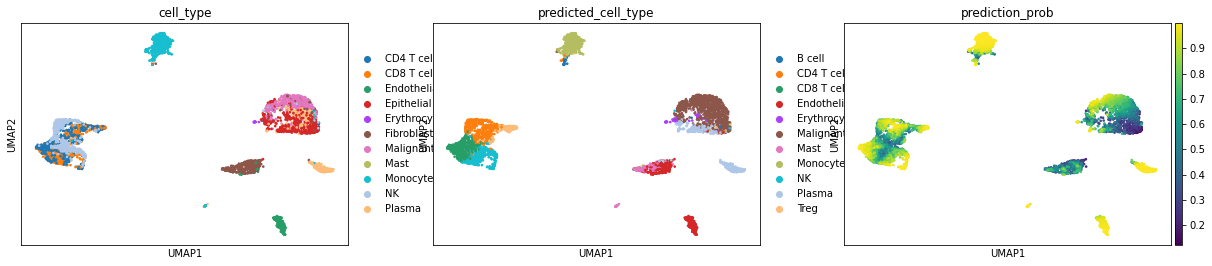

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


hnscc 0.881822709559398 0.8830994039607768


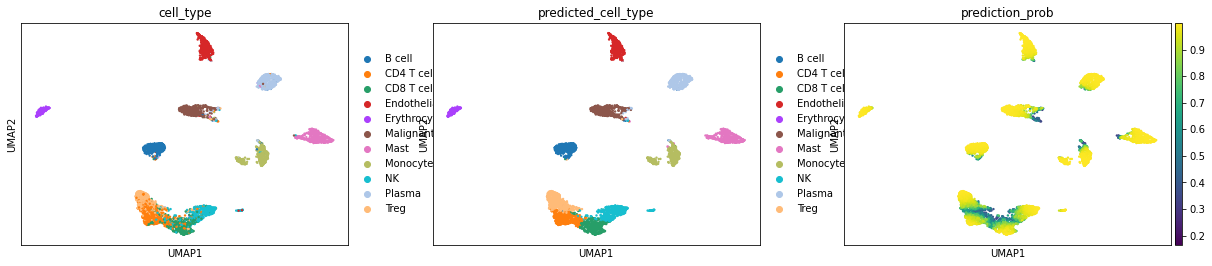

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


melanoma 0.827670642844871 0.7988668555240793


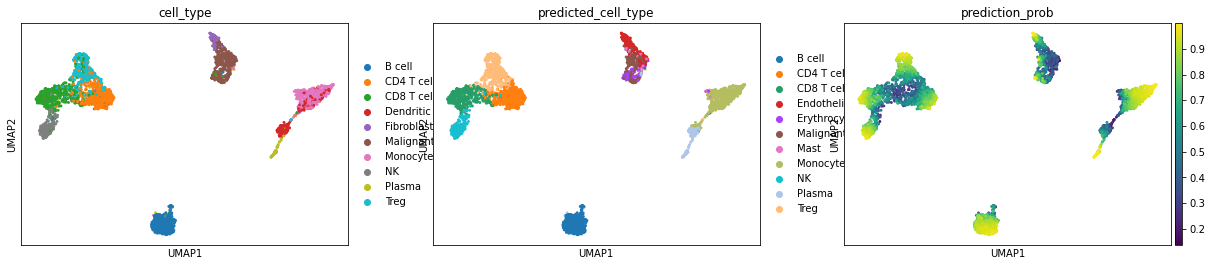

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


myeloma 0.7156290283427561 0.6906569825024761


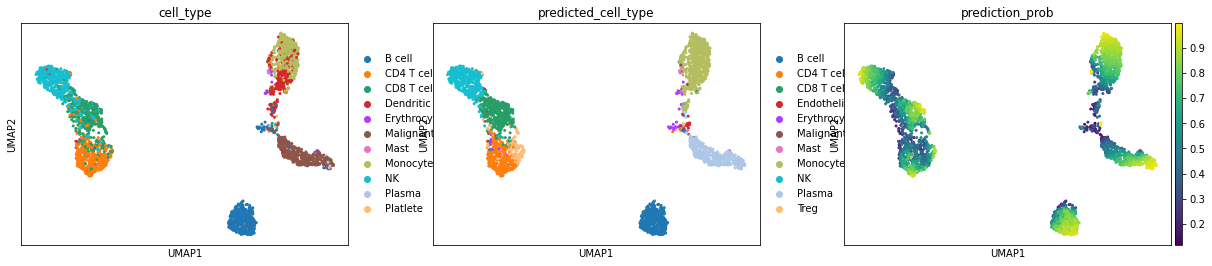

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


pdac 0.81556217170261 0.8272211720226843


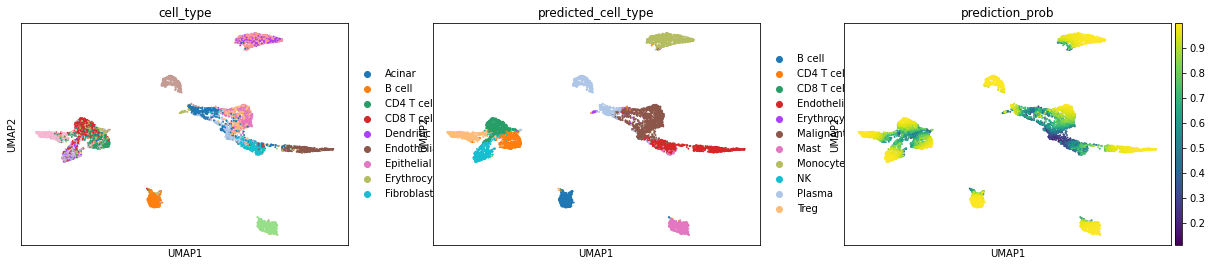

melanoma
epoch: 0, train loss: 2.521, val loss: 2.520,     vr loss: 0.432, vkl loss: 0.547, clf loss: 2.303, time: 2.07
epoch: 1, train loss: 2.508, val loss: 2.491,     vr loss: 0.403, vkl loss: 2.225, clf loss: 2.290, time: 2.09
epoch: 2, train loss: 2.377, val loss: 2.204,     vr loss: 0.244, vkl loss: 112.107, clf loss: 2.070, time: 2.09
epoch: 3, train loss: 1.995, val loss: 1.898,     vr loss: 0.198, vkl loss: 251.073, clf loss: 1.775, time: 2.08
epoch: 4, train loss: 1.760, val loss: 1.727,     vr loss: 0.189, vkl loss: 289.618, clf loss: 1.603, time: 2.08
epoch: 5, train loss: 1.635, val loss: 1.679,     vr loss: 0.187, vkl loss: 246.406, clf loss: 1.561, time: 2.08
epoch: 6, train loss: 1.602, val loss: 1.674,     vr loss: 0.186, vkl loss: 199.674, clf loss: 1.561, time: 2.08
epoch: 7, train loss: 1.592, val loss: 1.673,     vr loss: 0.185, vkl loss: 173.802, clf loss: 1.562, time: 2.08
epoch: 8, train loss: 1.586, val loss: 1.670,     vr loss: 0.185, vkl loss: 157.443, clf lo

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


brca 0.803222165933332 0.8036462699077954


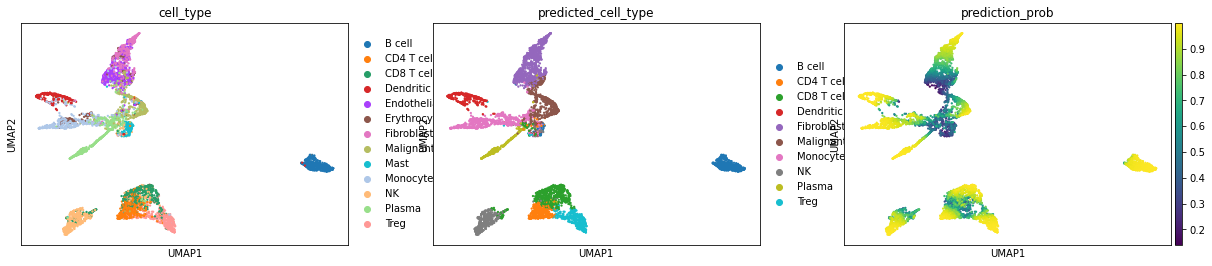

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


cesc 0.5665378902611411 0.5574285714285714


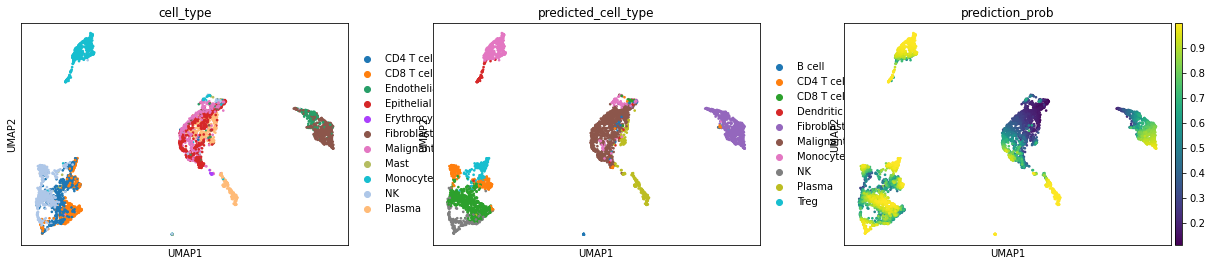

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


hnscc 0.781355348510579 0.7615


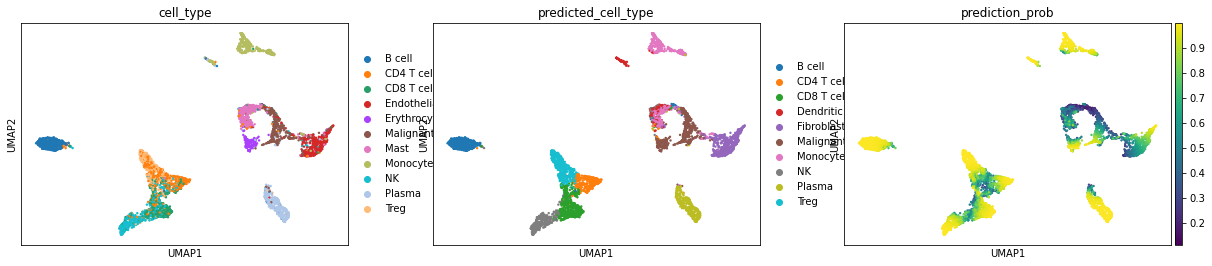

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


melanoma 0.9472308402122898 0.9473983508672164


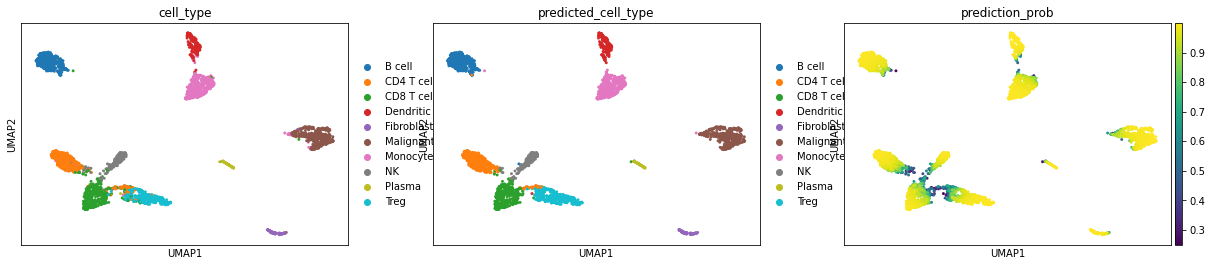

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


myeloma 0.7542806720500521 0.7432226621992081


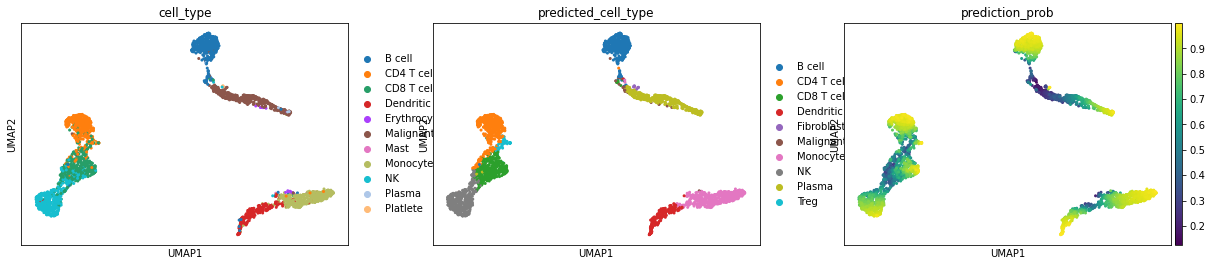

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


pdac 0.7575360211698982 0.7668


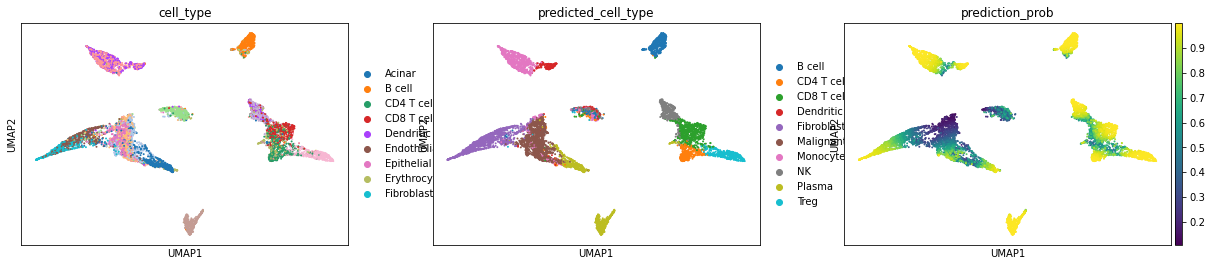

myeloma
epoch: 0, train loss: 2.623, val loss: 2.618,     vr loss: 0.437, vkl loss: 0.608, clf loss: 2.400, time: 1.60
epoch: 1, train loss: 2.612, val loss: 2.599,     vr loss: 0.416, vkl loss: 1.470, clf loss: 2.391, time: 1.84
epoch: 2, train loss: 2.528, val loss: 2.369,     vr loss: 0.283, vkl loss: 96.678, clf loss: 2.218, time: 1.81
epoch: 3, train loss: 2.137, val loss: 1.980,     vr loss: 0.212, vkl loss: 283.814, clf loss: 1.846, time: 1.79
epoch: 4, train loss: 1.820, val loss: 1.790,     vr loss: 0.204, vkl loss: 308.997, clf loss: 1.658, time: 1.78
epoch: 5, train loss: 1.731, val loss: 1.778,     vr loss: 0.201, vkl loss: 228.413, clf loss: 1.655, time: 1.76
epoch: 6, train loss: 1.711, val loss: 1.772,     vr loss: 0.200, vkl loss: 201.806, clf loss: 1.652, time: 1.78
epoch: 7, train loss: 1.691, val loss: 1.767,     vr loss: 0.199, vkl loss: 183.421, clf loss: 1.649, time: 1.77
epoch: 8, train loss: 1.682, val loss: 1.765,     vr loss: 0.199, vkl loss: 165.277, clf loss

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


brca 0.5616673202196685 0.6308851224105462


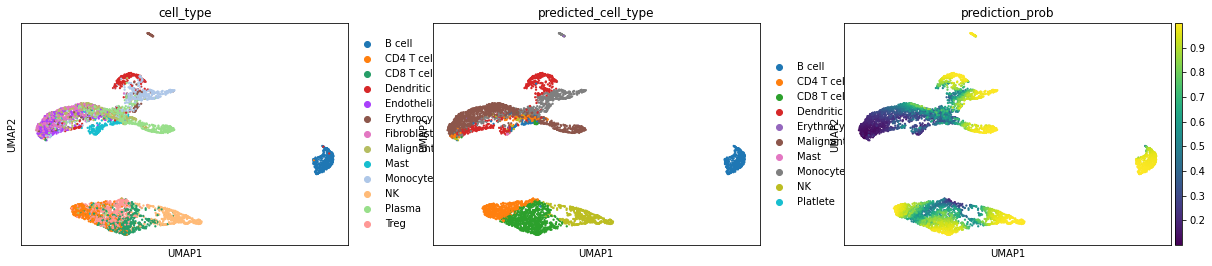

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


cesc 0.3657034804518115 0.3764783180026281


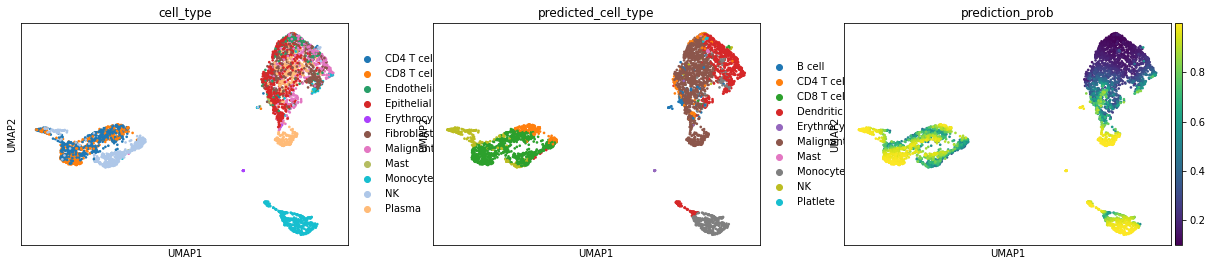

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


hnscc 0.49460394700441834 0.5265412996905499


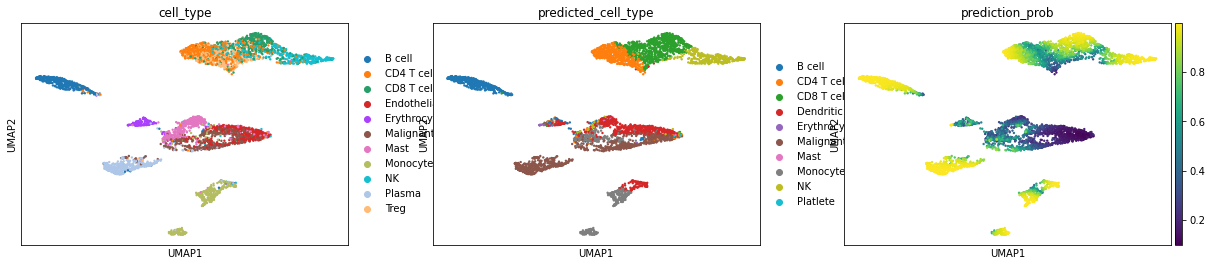

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


melanoma 0.8616386667114899 0.8710732984293194


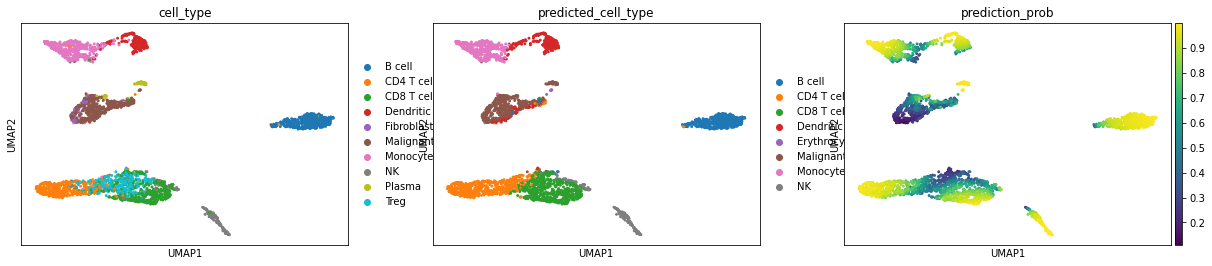

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


myeloma 0.9373945566732853 0.9381038647342995


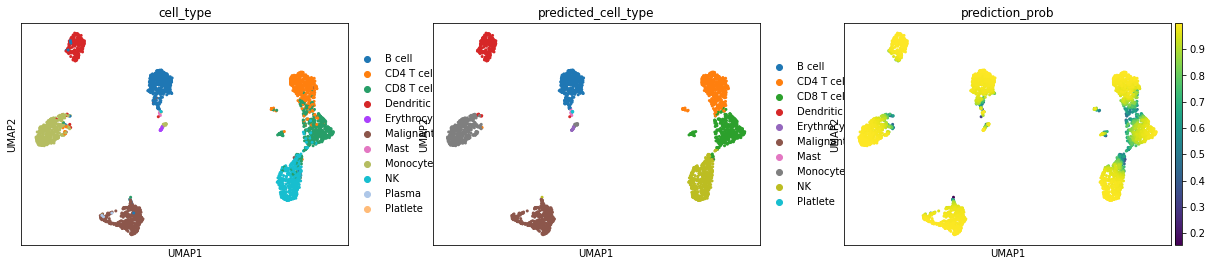

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


pdac 0.41887016486231804 0.4820459290187891


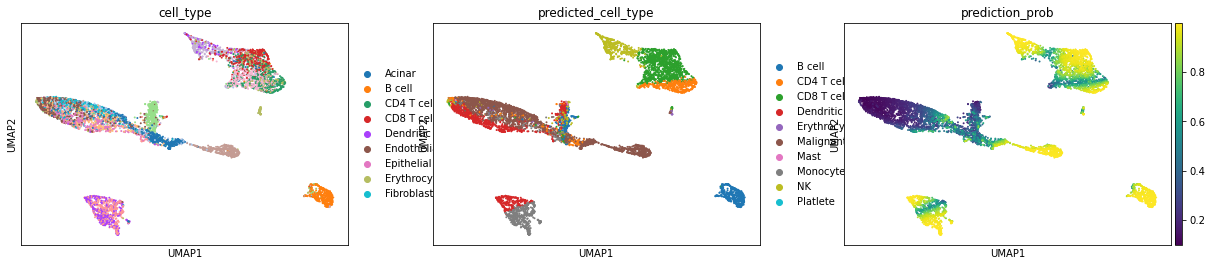

pdac
epoch: 0, train loss: 3.061, val loss: 3.056,     vr loss: 0.451, vkl loss: 0.803, clf loss: 2.830, time: 4.29
epoch: 1, train loss: 3.030, val loss: 2.942,     vr loss: 0.351, vkl loss: 62.802, clf loss: 2.760, time: 4.32
epoch: 2, train loss: 2.716, val loss: 2.504,     vr loss: 0.226, vkl loss: 386.815, clf loss: 2.352, time: 4.35
epoch: 3, train loss: 2.413, val loss: 2.357,     vr loss: 0.214, vkl loss: 359.377, clf loss: 2.214, time: 4.11
epoch: 4, train loss: 2.276, val loss: 2.297,     vr loss: 0.210, vkl loss: 326.020, clf loss: 2.159, time: 4.29
epoch: 5, train loss: 2.179, val loss: 2.255,     vr loss: 0.208, vkl loss: 267.162, clf loss: 2.124, time: 4.32
epoch: 6, train loss: 2.141, val loss: 2.255,     vr loss: 0.207, vkl loss: 236.280, clf loss: 2.128, time: 4.30
epoch: 7, train loss: 2.109, val loss: 2.246,     vr loss: 0.206, vkl loss: 199.281, clf loss: 2.123, time: 4.34
epoch: 8, train loss: 2.089, val loss: 2.238,     vr loss: 0.206, vkl loss: 176.873, clf loss:

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


brca 0.6999031201938097 0.6877174669450243


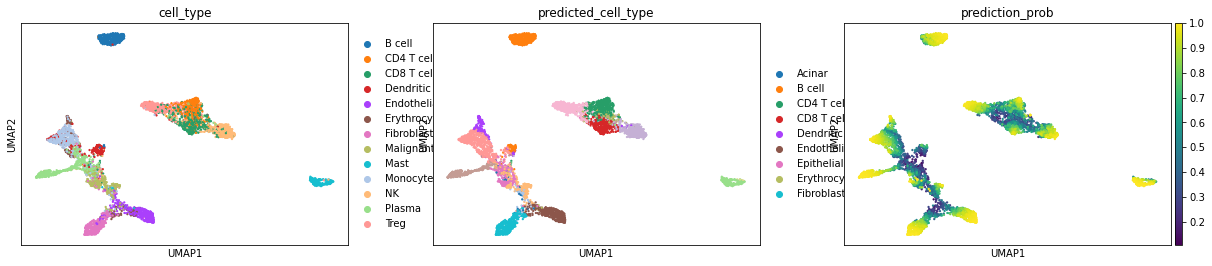

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


cesc 0.4800400458591797 0.431244153414406


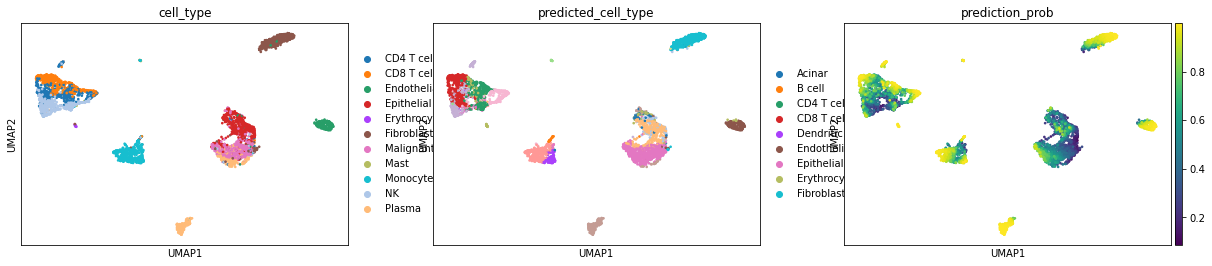

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


hnscc 0.7432598743251947 0.6992885983464718


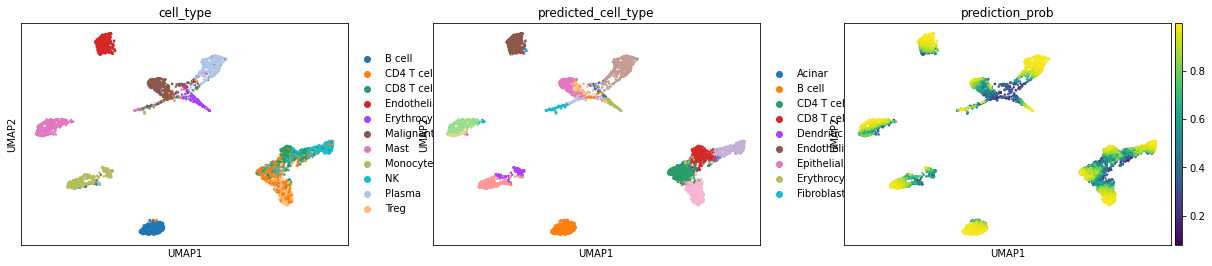

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


melanoma 0.7273354586951563 0.6957634347455217


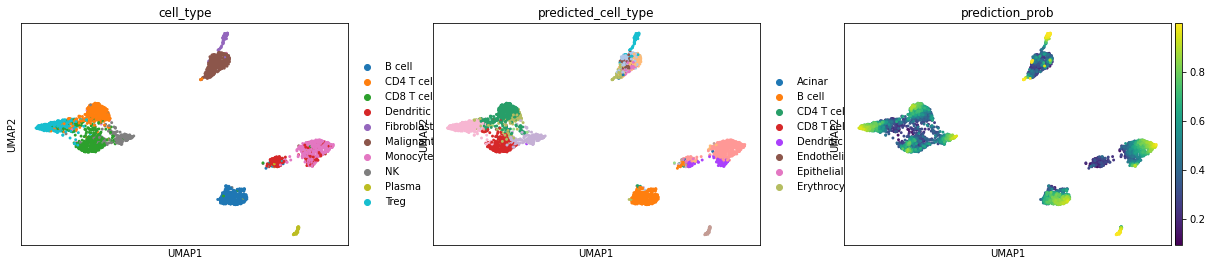

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


myeloma 0.5777029241598413 0.5420193470374849


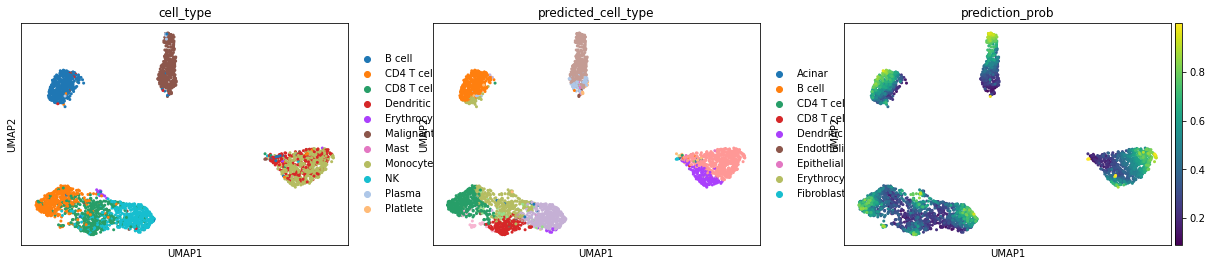

/home/estorrs/miniconda3/envs/pytorch_pollock/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


pdac 0.8728119207640155 0.8729387702927266


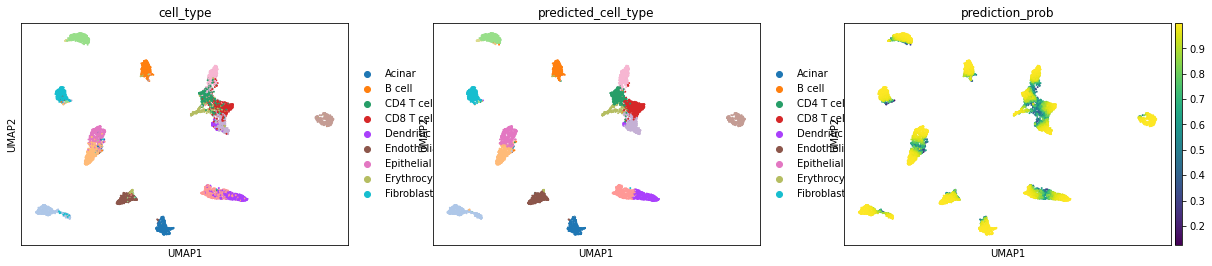

In [312]:
results_dict = {}
for train_fp, val_fp in zip(train_fps, val_fps):
    train_disease = train_fp.split('/')[-1].split('_')[0]
    print(train_disease)
    train_dl, val_dl = get_train_dataloaders(train_fp, val_fp)
    model, opt, scheduler = build_model(train_dl)
    fit_model(model, train_dl, val_dl, opt, scheduler)
    
    d = {}
    for fp in val_fps:
        disease = fp.split('/')[-1].split('_')[0]
        print(train_disease, disease)
        a = predict_adata(model, fp)
        d[disease] = a
    
    evaluate_results(d)
    results_dict[train_disease] = d